### Load the data from Excel

In [2]:
import pandas as pd
import numpy as np
import cmdstanpy as c
import seaborn as sns
import matplotlib.pyplot as plt
c.install_cmdstan()
print(c.__version__)

Installing CmdStan version: 2.29.2
Install directory: /home/cerquide/.cmdstan
CmdStan version 2.29.2 already installed
1.0.1


In [6]:

f = pd.ExcelFile( "../data/Cumulus Expansion dataset_without_negative_CE_values.xlsx")                                                  
print(f.sheet_names)
dfs = {}
for sheet_name in f.sheet_names:
    dfs[sheet_name] = pd.read_excel(f, sheet_name, skiprows=[0,1], header=None,usecols=[1,2,3,4,5,6])

['Area method', '3distance method', 'Score method']


In [7]:
dfs['Area method']


,1,2,3,4,5,6
0,178.072184,190.503002,178.518719,170.957529,194.124455,180.524075
1,110.545249,109.025768,112.780247,108.246239,117.683475,99.680823
2,61.779680,63.414298,76.387161,70.105727,69.782141,75.691881
3,35.756752,74.652821,64.172850,47.696356,58.703652,65.581084
4,7.413434,43.492802,34.984445,29.277502,37.427337,32.186628
...,...,...,...,...,...,...
227,141.696152,142.336361,233.908814,121.368418,144.086331,260.232729
228,53.737893,47.563056,58.645541,34.494464,42.131194,62.355879
229,81.012607,72.006168,76.574489,73.516026,67.435111,81.598661
230,132.129189,139.583314,124.941917,126.100468,145.678629,155.866156


In [8]:
def get_q(v):
    return np.log((v+100)/100)

def get_matrix(xls_df, judges=3, repeats=2, do_log=True):
    objects = len(xls_df.index)
    x = np.zeros((objects, judges, repeats))
    x[:,0,0] = xls_df[1]
    x[:,0,1] = xls_df[4]
    x[:,1,0] = xls_df[2]
    x[:,1,1] = xls_df[5]
    x[:,2,0] = xls_df[3]
    x[:,2,1] = xls_df[6]
    if do_log:
        x = get_q(x)
    return x

## Area method analysis

In [9]:
x = get_matrix(dfs['Area method'])

### Let's take a look at the data

In [10]:
def describe_data(x):
    x_min = np.min(x)
    x_max = np.max(x)
    print("Observations are in the range :[", x_min,"-", x_max,"]")
    x_mean = np.mean(x)
    x_median = np.median(x)
    print("And their mean is ", x_mean, " and their median is ", x_median)
    x_var = np.var(x)
    print("The variance of x is ", x_var, " and its square root is ", np.std(x))
    return {"l_mu":x_min, "u_mu":x_max}

In [11]:
describe_data(x)

Observations are in the range :[ 0.0006567629664933187 - 1.495749920914788 ]
And their mean is  0.5800906237245244  and their median is  0.5555164285723108
The variance of x is  0.06598398049183929  and its square root is  0.25687347175572506


{'l_mu': 0.0006567629664933187, 'u_mu': 1.495749920914788}

<AxesSubplot:ylabel='Density'>

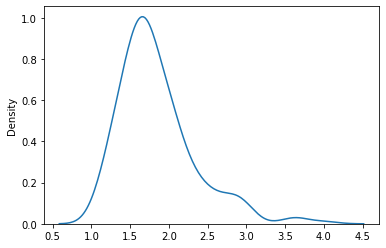

In [12]:
sns.kdeplot(np.exp(np.mean(x, axis=(1,2))))

<AxesSubplot:ylabel='Density'>

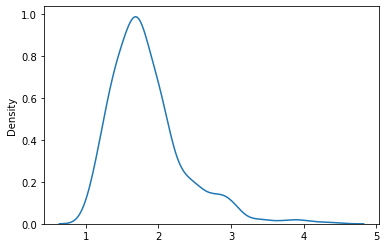

In [13]:
sns.kdeplot(np.exp(x.flatten()))

In [30]:
x_sigma_T = np.std(np.mean(x, axis=(1,2)))
icc_approx = (x_sigma_T*x_sigma_T) / np.var(x)
print("First ICC approximation:", icc_approx)

First ICC approximation: 0.9106035142403921


In [31]:
data = {
    "N": x.shape[0],
    "J": x.shape[1],
    "R": x.shape[2],
    "x": x,
    "l_mu": np.min(x),
    "u_mu": np.max(x),
    "l_sigma_T": 0.0,
    "u_sigma_T": np.std(x)*1.1,
    "l_sigma_J": 0.0,
    "u_sigma_J": np.std(x)*1.1,
    "l_sigma_I": 0.0,
    "u_sigma_I": np.std(x)*1.1
}

def bayesian_analysis(data):
    m = c.CmdStanModel(stan_file="../stan/va.stan")
    posterior = m.sample(data=data, iter_sampling=200, adapt_delta=0.999)
    return m, posterior

def describe_ba(posterior):
    print(posterior.diagnose())
    l_mu = np.exp(posterior.stan_variable("mu"))
    sns.kdeplot(l_mu)
    plt.title("Density plot for mu")
    plt.show()
    print("The median of mu is:", np.median(np.exp(posterior.stan_variable("mu"))))
    l_sigma_T=posterior.stan_variable("sigma_T")
    #print(l_sigma_T)
    sns.kdeplot(l_sigma_T)
    plt.title("Density plot for sigma_T")
    plt.show()
    print("The median of sigma_T is ",np.median(l_sigma_T))
    l_sigma_J=posterior.stan_variable("sigma_J")
    sns.kdeplot(l_sigma_J)
    plt.title("Density plot for sigma_J")
    plt.show()
    print("The median of sigma_J is ",np.median(l_sigma_J))
    l_sigma_I=posterior.stan_variable("sigma_I")
    for i in range(3):
        sns.kdeplot(l_sigma_I[:,i], label="obs_"+str(i+1))
    plt.legend()
    plt.title("Density plot for the sigma_I of each of the observers")
    plt.show()
    for i in range(3):
        print("The median of sigma_I for observer ", i+1," is ", np.median(l_sigma_I[:,i]))
    l_a = posterior.stan_variable("a")
    for i in range(3):
        sns.kdeplot(l_a[:,i], label="obs_"+str(i+1))
    plt.legend()
    plt.title("Density plot of the bias estimate of each observer")
    plt.show()
    l_a_medians = np.median(l_a, axis=0)
    for i in range(3):
        print("The median of the bias for observer ", i+1," is ", l_a_medians[i])
    l_b = posterior.stan_variable("b")
    for i in range(5):
        sns.kdeplot(l_b[:,i]+l_mu, label="oocyte_"+str(i+1))
    plt.legend()
    plt.title("Density plot of the real growth of the first 5 oocytes")
    plt.show()

def bayesian_icc(posterior):
    l_sigma_I=posterior.stan_variable("sigma_I")
    l_sigma_T=posterior.stan_variable("sigma_T")
    l_sigma_J=posterior.stan_variable("sigma_J")
    l_sigma_E=np.sqrt(np.mean(l_sigma_I*l_sigma_I,axis=1))
    rho=(l_sigma_T*l_sigma_T)/(l_sigma_T*l_sigma_T + l_sigma_J*l_sigma_J + l_sigma_E*l_sigma_E)
    return rho

def show_icc(rho):
    sns.kdeplot(rho)
    plt.title("Density plot of the ICC")
    plt.show()
    print("The median ICC value is ", np.median(rho))
    print("The mean ICC value is ", np.mean(rho))
    #sns.kdeplot(l_sigma_E)
    
def show_iccs(rhos, labels):
    
    for i, rho  in enumerate(rhos):
        sns.kdeplot(rho, label=labels[i])
        #plt.label(labels[i])
        plt.title("Density plot of the ICCs")
        print("The median ICC value for " + labels[i] + " is ", np.median(rho))
        #print("The mean ICC value for " + labels[i] + " is ", np.mean(rho))
    plt.legend()
    plt.show()
    #sns.kdeplot(l_sigma_E)

In [32]:
m_area, posterior_area = bayesian_analysis(data)

INFO:cmdstanpy:compiling stan file /home/cerquide/prj/cumulus_expansion_variance_analysis/stan/va.stan to exe file /home/cerquide/prj/cumulus_expansion_variance_analysis/stan/va
INFO:cmdstanpy:compiled model executable: /home/cerquide/prj/cumulus_expansion_variance_analysis/stan/va
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


Processing csv files: /tmp/tmpi5i3vbkd/va-20220506101032_1.csv, /tmp/tmpi5i3vbkd/va-20220506101032_2.csv, /tmp/tmpi5i3vbkd/va-20220506101032_3.csv, /tmp/tmpi5i3vbkd/va-20220506101032_4.csv

Checking sampler transitions treedepth.
200 of 800 (25.00%) transitions hit the maximum treedepth limit of 10, or 2^10 leapfrog steps.
Trajectories that are prematurely terminated due to this limit will result in slow exploration.
For optimal performance, increase this limit.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

The following parameters had split R-hat greater than 1.05:
  mu, b[1], b[2], b[3], b[4], b[5], b[6], b[7], b[8], b[9], b[10], b[11], b[12], b[13], b[14], b[15], b[16], b[17], b[18], b[19], b[20], b[21], b[22], b[23], b[24], b[25], b[26], b[27], b[28], b[29], b[30], b[31], b[32], b[33], b[34], b[35], b[36], b[37], b[38], b[39], b[40

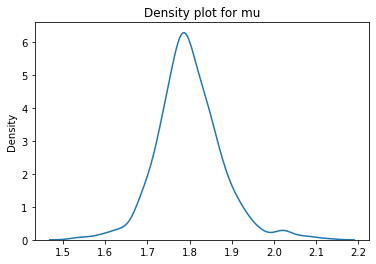

The median of mu is: 1.7933143516380623


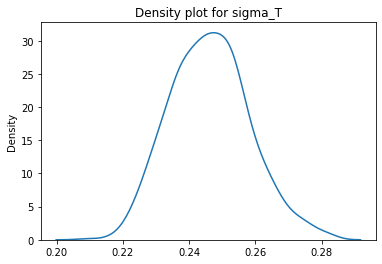

The median of sigma_T is  0.24599500000000002


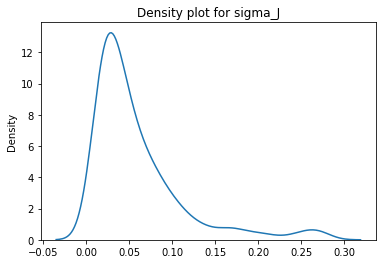

The median of sigma_J is  0.0417826


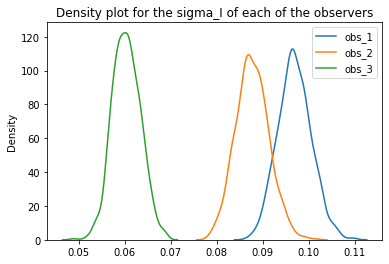

The median of sigma_I for observer  1  is  0.0968092
The median of sigma_I for observer  2  is  0.0876049
The median of sigma_I for observer  3  is  0.0602986


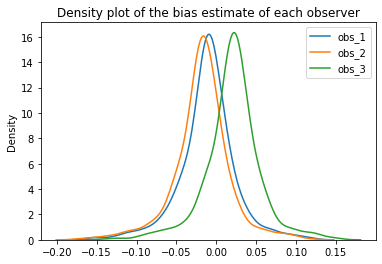

The median of the bias for observer  1  is  -0.0102293
The median of the bias for observer  2  is  -0.0169671
The median of the bias for observer  3  is  0.02198595


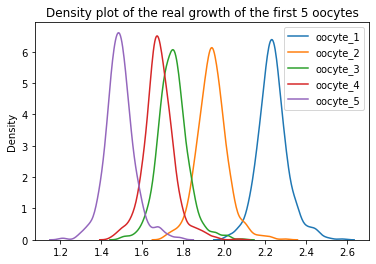

In [29]:
describe_ba(posterior_area)

### Now, we compute the ICC

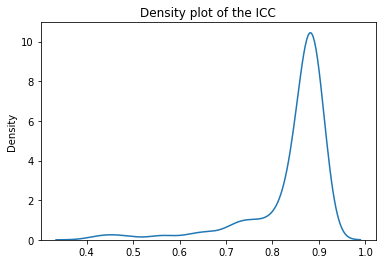

The median ICC value is  0.8752790966046551
The mean ICC value is  0.8404769482539943


In [33]:
rho_area = bayesian_icc(posterior_area)
show_icc(rho_area)

### A more traditional way, by fitting the very same model using maximum likelihood and assessing the ICC from the ML parameters 

In [34]:
def ICC(sigma_T, sigma_J, sigma_I):
    sT2= sigma_T*sigma_T
    sJ2= sigma_J*sigma_J
    return sT2 / (sT2 + sJ2 + np.mean(sigma_I*sigma_I))

def ml_icc(m, posterior, data):
    inits = {
        "mu": np.median(posterior.stan_variable("mu")),
        "sigma_T": np.median(posterior.stan_variable("sigma_T")),
        "sigma_J": np.median(posterior.stan_variable("sigma_J")),
        "sigma_I": np.median(posterior.stan_variable("sigma_I"), axis=0),
        "a": np.median(posterior.stan_variable("a"), axis=0),
        "b": np.median(posterior.stan_variable("b"), axis=0)
    }
    #print(inits)
    opt = m.optimize(data=data,
                     algorithm="lbfgs",
                     inits=inits,
                     init_alpha=1e-10,
                     #output_dir=".",
                     #show_console=True,
                     tol_rel_grad=1e2,
                     tol_rel_obj=1e2,
                     iter=100000
                     )
    icc_ml = ICC(opt.stan_variable("sigma_T"), opt.stan_variable("sigma_J"), opt.stan_variable("sigma_I"))
    print("The ICC estimated by maximum likelihood is ", icc_ml)
    return opt

In [35]:
opt_area = ml_icc(m_area, posterior_area, data) 

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


The ICC estimated by maximum likelihood is  0.8985758903554726


In [36]:
opt_area.stan_variables()

{'mu': 0.580501,
 'sigma_T': 0.244343,
 'sigma_J': 0.0164002,
 'sigma_I': array([0.098179 , 0.0889449, 0.0431203]),
 'a': array([-0.00807659, -0.0147905 ,  0.0228667 ]),
 'b': array([ 4.35080e-01,  1.36604e-01, -4.40960e-02, -1.10718e-01,
        -3.08810e-01,  1.19957e-01, -4.06064e-01, -2.83410e-01,
         4.46225e-01, -9.24882e-02, -1.97655e-01, -8.36157e-02,
         1.86676e-01, -3.83789e-02, -5.67093e-02, -6.58928e-02,
         6.96073e-02, -1.11305e-02,  1.71672e-01,  2.07621e-01,
         5.13937e-01, -2.42387e-01, -1.73771e-01, -1.34902e-01,
         3.14883e-01, -9.37158e-03, -1.99064e-01,  1.51063e-01,
         8.59450e-02,  6.55054e-02,  1.14425e-01,  2.98648e-01,
        -2.07330e-02, -6.13856e-02, -3.07649e-01, -1.27201e-01,
        -2.18248e-01,  8.39019e-02,  1.86311e-01, -2.94262e-01,
        -3.17324e-01,  9.38026e-02, -1.13776e-01, -4.88691e-02,
        -2.88654e-01, -8.84663e-02, -2.49080e-01, -2.86578e-01,
        -1.00012e-01,  5.10722e-01, -3.38492e-03, -1.7879

# 3 distance method analysis

In [146]:
x3d = get_matrix(dfs['3distance method'])

Since there are some errors in the data, we remove those rows

In [147]:
rows_with_errors = np.unique(np.argwhere(np.isnan(x3d))[:,0])
x3d = np.delete(x3d, list(rows_with_errors), axis=0)
print("The rows with problems appear in the excel file with numbers ", rows_with_errors+3)

The rows with problems appear in the excel file with numbers  [111 127 146 152 192 211 222]


### Let's take a look at the data

In [148]:
describe_data(x3d)

Observations are in the range :[ 0.0015312858028130147 - 1.5127944571306082 ]
And their mean is  0.43167008056067474  and their median is  0.42458732781698005
The variance of x is  0.05032300418874117  and its square root is  0.22432789436167133


{'l_mu': 0.0015312858028130147, 'u_mu': 1.5127944571306082}

<AxesSubplot:ylabel='Density'>

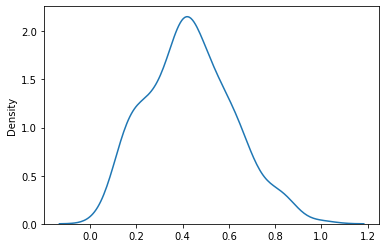

In [149]:
sns.kdeplot(np.mean(x3d, axis=(1,2)))

In [150]:
x_sigma_T = np.std(np.mean(x3d, axis=(1,2)))
icc_approx3d = (x_sigma_T*x_sigma_T) / np.var(x3d)
print("First ICC approximation:", icc_approx3d)

First ICC approximation: 0.6705934478340552


In [151]:
data3d = {
    "N": x3d.shape[0],
    "J": x3d.shape[1],
    "R": x3d.shape[2],
    "x": x3d,
    "l_mu": np.min(x3d),
    "u_mu": np.max(x3d),
    "l_sigma_T": 0.0,
    "u_sigma_T": np.std(x3d)*1.1,
    "l_sigma_J": 0.0,
    "u_sigma_J": np.std(x3d)*1.1,
    "l_sigma_I": 0.0,
    "u_sigma_I": np.std(x3d)*1.1
}


In [152]:
m3d, posterior3d = bayesian_analysis(data3d)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


Processing csv files: /tmp/tmpddvo_hhg/annelies-20220301153339_1.csv, /tmp/tmpddvo_hhg/annelies-20220301153339_2.csv, /tmp/tmpddvo_hhg/annelies-20220301153339_3.csv, /tmp/tmpddvo_hhg/annelies-20220301153339_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
1 of 800 (0.12%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete.



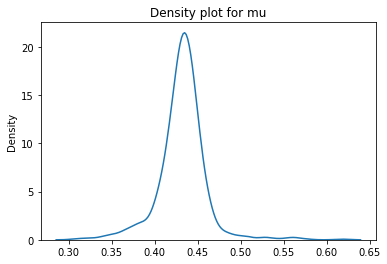

The median of mu is: 0.43314149999999996


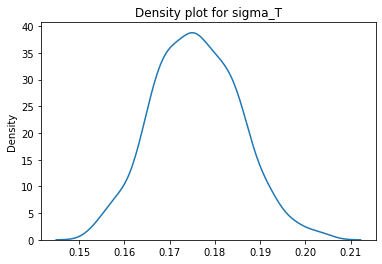

The median of sigma_T is  0.17555700000000002


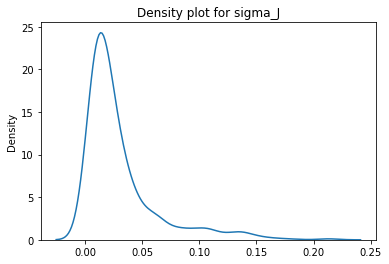

The median of sigma_J is  0.01901545


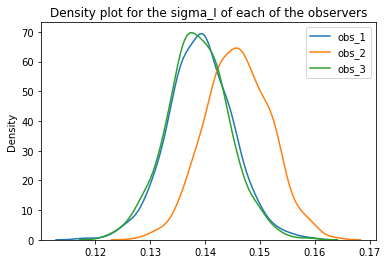

The median of sigma_I for observer  1  is  0.139171
The median of sigma_I for observer  2  is  0.14583000000000002
The median of sigma_I for observer  3  is  0.138646


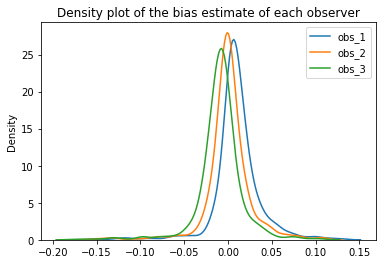

The median of the bias for observer  1  is  0.008328835
The median of the bias for observer  2  is  0.0001538625
The median of the bias for observer  3  is  -0.00779803


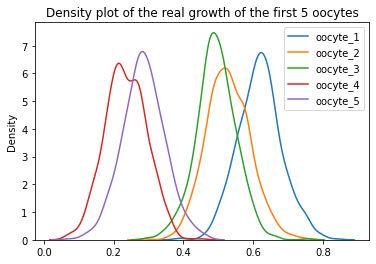

In [153]:
describe_ba(posterior3d)

### Now, we compute the ICC

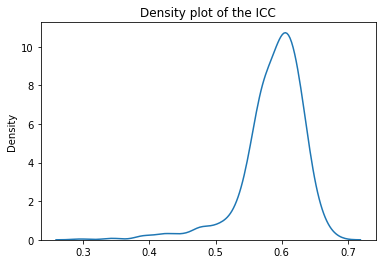

The median ICC value is  0.5954261484171874
The mean ICC value is  0.58732620977256


In [154]:
rho3d = bayesian_icc(posterior3d)
show_icc(rho3d)

### A more traditional way, by fitting the very same model using maximum likelihood and assessing the ICC from the ML parameters 

In [155]:
opt3d = ml_icc(m3d, posterior3d, data3d) 

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


The ICC estimated by maximum likelihood is  0.6886070693166936


In [156]:
opt3d.stan_variables()

{'mu': 0.433698,
 'sigma_T': 0.194187,
 'sigma_J': 2.1677e-07,
 'sigma_I': array([0.136614, 0.129616, 0.12527 ]),
 'a': array([ 1.60985e-11,  1.87542e-12, -1.34538e-11]),
 'b': array([ 1.79117e-01,  8.79136e-02,  6.13160e-02, -2.09260e-01,
        -1.60954e-01,  8.62294e-02, -1.22068e-01,  4.61568e-05,
         2.98013e-01, -7.75320e-02, -2.51307e-01,  5.92892e-04,
        -1.43389e-01,  3.86434e-02,  8.10496e-04, -1.20844e-01,
         2.92232e-02, -6.50826e-02, -5.35041e-03, -2.13039e-01,
         1.70313e-01, -1.84696e-01, -2.62305e-01, -1.42015e-01,
         1.12652e-01,  2.36002e-01, -2.84431e-01,  6.61734e-02,
         1.21365e-02,  5.22474e-02, -2.63339e-01,  5.44887e-02,
        -4.11749e-02, -3.39038e-02, -1.70690e-01, -2.78370e-01,
        -6.82476e-02, -3.16552e-03,  1.68662e-01, -2.07384e-01,
         1.14688e-01,  1.85124e-01, -9.95935e-02,  4.67437e-03,
        -3.84650e-02,  1.39704e-01, -3.04000e-02, -3.34475e-02,
         3.32496e-02,  1.85659e-01,  8.07394e-02, -3.237

# Score method analysis

In [157]:
x_s = get_matrix(dfs['Score method'], do_log=False)

In [158]:
describe_data(x_s)

Observations are in the range :[ 0.0 - 4.0 ]
And their mean is  2.4123563218390807  and their median is  3.0
The variance of x is  0.827088700620954  and its square root is  0.9094441712501949


{'l_mu': 0.0, 'u_mu': 4.0}

In [159]:
x_sigma_T = np.std(np.mean(x_s, axis=(1,2)))
icc_approx = (x_sigma_T*x_sigma_T) / np.var(x_s)
print("First ICC approximation:", icc_approx)

First ICC approximation: 0.4365825959990514


In [160]:
data_s = {
    "N": x_s.shape[0],
    "J": x_s.shape[1],
    "R": x_s.shape[2],
    "x": x_s,
    "l_mu": np.min(x_s),
    "u_mu": np.max(x_s),
    "l_sigma_T": 0.0,
    "u_sigma_T": np.std(x_s)*1.1,
    "l_sigma_J": 0.0,
    "u_sigma_J": np.std(x_s)*1.1,
    "l_sigma_I": 0.0,
    "u_sigma_I": np.std(x_s)*1.1
}


In [161]:
m_s, posterior_s = bayesian_analysis(data_s)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


Processing csv files: /tmp/tmpddvo_hhg/annelies-20220301153353_1.csv, /tmp/tmpddvo_hhg/annelies-20220301153353_2.csv, /tmp/tmpddvo_hhg/annelies-20220301153353_3.csv, /tmp/tmpddvo_hhg/annelies-20220301153353_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



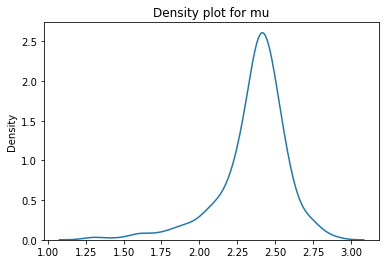

The median of mu is: 2.3994400000000002


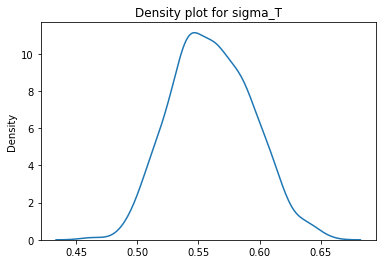

The median of sigma_T is  0.55987


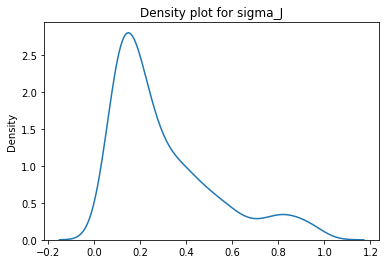

The median of sigma_J is  0.2173655


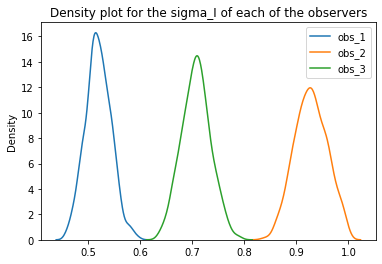

The median of sigma_I for observer  1  is  0.5182775
The median of sigma_I for observer  2  is  0.927243
The median of sigma_I for observer  3  is  0.7070004999999999


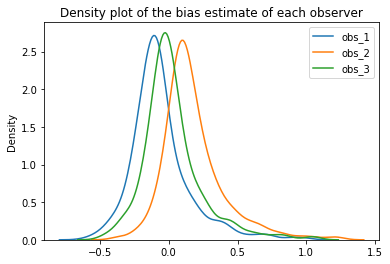

The median of the bias for observer  1  is  -0.0911355
The median of the bias for observer  2  is  0.12625350000000002
The median of the bias for observer  3  is  -0.009966389999999999


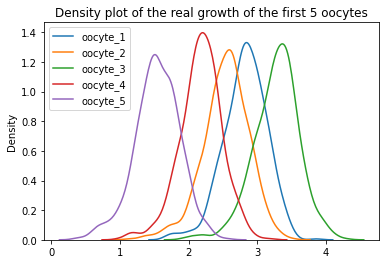

In [162]:
describe_ba(posterior_s)

### Now, we compute the ICC

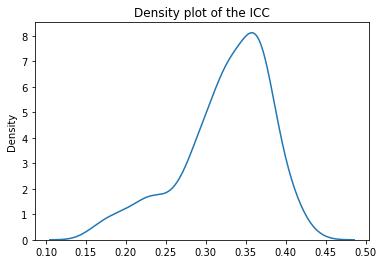

The median ICC value is  0.3357558211556881
The mean ICC value is  0.32484140168093567


In [163]:
rho_s = bayesian_icc(posterior_s)
show_icc(rho_s)

### A more traditional way, by fitting the very same model using maximum likelihood and assessing the ICC from the ML parameters 

In [164]:
opt_s = ml_icc(m_s, posterior_s, data_s) 

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


The ICC estimated by maximum likelihood is  0.3572783272714983


The median ICC value for Area is  0.8733064789273424
The median ICC value for 3 distances is  0.5954261484171874
The median ICC value for Score is  0.3357558211556881


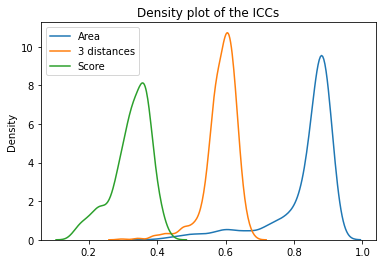

In [168]:
show_iccs([rho_area,rho3d,rho_s],["Area","3 distances","Score"])